In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle

import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9777bdaad0>]],
      dtype=object)

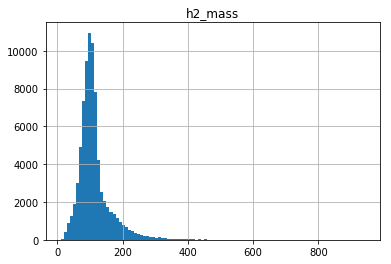

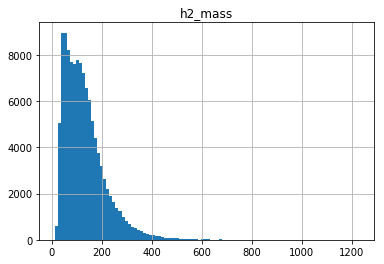

In [2]:
# *** 0. Import Dataset
hh_raw, qcd_raw = importDatasets()

variableNames = ['hh_mass', 'h1_mass', 'h2_mass']

hh_raw.hist(column=variableNames[2], bins=100)
qcd_raw.hist(column=variableNames[2], bins=100)


In [3]:
def setupAndTrainBDT(all_data, all_labels, _testSize=0.3, _saveModel=False, _maxDepth=8, _eta=0.3, _steps=25, _modelName='reduced_bdt'):
    """setup and train BDT"""
    
    # *** 1. Split dataset into test + train, make correct input objects
    data_train, data_test, label_train, label_test = train_test_split(all_data, all_labels, test_size=_testSize)

    D_train = xgb.DMatrix(data_train, label=label_train)
    D_test = xgb.DMatrix(data_test, label=label_test)
    
    # *** 2. Define XGB model 
    param = {
        'eta': _eta, 
        'max_depth': _maxDepth,  
        'objective': 'multi:softprob',  
        #'objective': 'reg:logistic',  
        #'objective': 'binary:logistic',
        'num_class': 2} 

    steps = _steps  # The number of training iterations

    # *** 3. Train model 
    #model = xgb.train(param, D_train, steps)
    #model = xgb.train(param, D_train, steps, evals=[(D_train, 'error'), (D_test, 'error'), (D_test, 'logloss'), (D_test, 'auc')])
    model = xgb.train(param, D_train, steps, evals=[(D_test, 'logloss')], early_stopping_rounds=3)
    
    # *** 4. Evaluate model
    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))
    
    # *** 5. Dump .txt of trees and leaves with decisions if desired
    if (_saveModel):
        model.dump_model('tree.{0}.txt'.format(_modelName))
        pickle.dump(model, open('model.{0}.pkl'.format(_modelName), 'wb'))
        # Make a visual of decision tree
        #xgb.plot_tree(model,num_trees=1)
        #plt.rcParams['figure.figsize'] = [2000, 400]
        #plt.show()
        #plt.savefig('tree0.png')
    
    
    return model

def setupGridAndTrainBDT(_modelName, all_data, all_labels, _testSize=0.3, _saveModel=False):
    """setup and train using grid of hyperparameters BDT"""
    
    # *** 1. Split dataset into test + train, make correct input objects
    data_train, data_test, label_train, label_test = train_test_split(all_data, all_labels, test_size=_testSize)

    D_train = xgb.DMatrix(data_train, label=label_train)
    D_test = xgb.DMatrix(data_test, label=label_test)
    
    # *** 2. Define XGB hyper-parameter grid 
    parameters = {
        "eta"    : [0.10, 0.15, 0.20, 0.25, 0.30 ] ,
        "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
        #"min_child_weight" : [ 1, 3, 5, 7 ],
        #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
        "objective": ["multi:softprob"],
        "num_class": [2]
        }

    steps = 5  # The number of training iterations

    # *** 3. Perform grid optimization 
    clf = xgb.XGBClassifier()
    grid = GridSearchCV(clf,
                        parameters, n_jobs=4,
                        #scoring="neg_log_loss",
                        scoring="f1",
                        cv=3,
                        verbose = 3)

    grid_result = grid.fit(data_train, label_train)
    best_params = grid_result.best_params_
    print(best_params, type(best_params))
    
    # *** 4. Train model 
    model = xgb.train( best_params, D_train, steps)
    
    
    # *** 5. Evaluate model
    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))
    
    # *** 5. Dump .txt of trees and leaves with decisions if desired
    if (_saveModel):
        model.dump_model('gridTree.{0}.txt'.format(_modelName))
        pickle.dump(model, open('grid-model.{0}.pkl'.format(_modelName), 'wb'))

        # Make a visual of decision tree
        #xgb.plot_tree(model,num_trees=1)
    
    
    return model

In [4]:
def plotBDTOutputAndTree(_model, _modelName, _signalData, _signalLabels, _bkgData, _bkgLabels, _savePlots=False):
    """make plots of BDT outputs for signal+background probabilities and tree plot"""
    
    # *** 1. Make some 1D histograms of signal decision outputs
    signal_DMatrix = xgb.DMatrix(_signalData, label=_signalLabels)
    preds_signal = _model.predict(signal_DMatrix)
    sig_pred_isBkg     = [x[0] for x in preds_signal]
    sig_pred_isSignal  = [x[1] for x in preds_signal]
    #plt.hist(preds_hh)

    # *** 2. Make some 1D histograms of background decision outputs
    bkg_DMatrix = xgb.DMatrix(_bkgData, label=_bkgLabels)
    preds_bkg = _model.predict(bkg_DMatrix)
    bkg_pred_isBkg    = [x[0] for x in preds_bkg]
    bkg_pred_isSignal = [x[1] for x in preds_bkg]
    #plt.hist(preds_qcd)
    
    # *** 3. Plot feature importance
    if(_savePlots):
        xgb.plot_importance(_model)
        _fig = plt.gcf()
        _scope    = _modelName.split(' ')[0].lower()
        _variable = 'featureImportance'
        _filename  = _scope + '_' + _variable
        _fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    # *** 4. Make dict for plotting with borrowed functions
    _nBins = 40
    predictionResults = {'hh_pred_isSignal':sig_pred_isSignal, 'hh_pred_isBkg':sig_pred_isBkg, 'qcd_pred_isSignal':bkg_pred_isSignal, 'qcd_pred_isBkg':bkg_pred_isBkg,}
    compareManyHistograms( predictionResults, ['hh_pred_isSignal', 'qcd_pred_isSignal'], 2, 'Signal Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _normed=True, _savePlot=_savePlots )
    compareManyHistograms( predictionResults, ['hh_pred_isBkg', 'qcd_pred_isBkg'], 2, 'Bkg Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _normed=True, _savePlot=_savePlots )
    xgb.plot_importance(_model)

    # *** 5. Make plot of 0th tree
    #xgb.plot_tree(_model,num_trees=0)
    #plt.gcf().set_size_inches(100, 67)
    #_fig = plt.gcf()
    #plt.show()
    
    #if(_savePlots):
    #    _variable = 'firstTrainedDecisionTree'
    #    _filename  = _scope + '_' + _variable
    #    _fig.savefig( _filename+'.png' )
        
    # *** 6. restore figure defaults
    plt.rcParams['figure.figsize'] = [6.4, 4.8]

    
    return


In [41]:
def makeDatasetsAndTrainModel(_modelName, _variables, _testingFraction, _signalDF, _bkgDF, _makePlots=False, _runGridOpt=False):

    print("####### {0} #######".format(_modelName))
    # get datasets for testing and training
    _data_train, _data_test, _labels_train, _labels_test = makeTestTrainSamplesWithUserVariables(_signalDF.copy(), _bkgDF.copy(), _variables, _testingFraction)

    # ***  XXXX. Reduce amount of training data. [FIXME] this is 100% a temporary test
    #maxTrain = int( (0.6/(1-_testingFraction)) * len(_data_train) )
    #_data_train = _data_train[:maxTrain]
    #_labels_train = _labels_train[:maxTrain]
                  
    # get hh and qcd split testing data
    _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test = returnTestSamplesSplitIntoSignalAndBackground(_data_test, _labels_test)
    # train model
    _model = setupAndTrainBDT(_data_train, _labels_train, _maxDepth=11, _eta=0.1, _steps=40)
    
    # *** B. do some plotting
    if _makePlots:
        plotBDTOutputAndTree(_model, _modelName, _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test, _savePlots=False)
        
    # *** C. Make predictions 
    _sig_DMatrix = xgb.DMatrix(_data_signal_test, label=_labels_signal_test)
    _preds_sig   = _model.predict(_sig_DMatrix)
    _bkg_DMatrix = xgb.DMatrix(_data_bkg_test, label=_labels_bkg_test)
    _preds_bkg   = _model.predict(_bkg_DMatrix)

    _sig_pred_isSignal   = [x[1] for x in _preds_sig]
    _bkg_pred_isSignal  = [x[1] for x in _preds_bkg]

    # *** D. Calculate significance 
    returnBestCutValue('BDT', _sig_pred_isSignal.copy(), _bkg_pred_isSignal.copy(), _minBackground=4e5, _testingFraction=_testingFraction)
    
    # *** E. run grid optimization
    if _runGridOpt:
        _model_gridOpt = setupGridAndTrainBDT( _modelName, _data_train, _labels_train, _saveModel=True)
        plotBDTOutputAndTree(_model_gridOpt, 'grid_'+_modelName, _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test, _savePlots=False)
        return _model_gridOpt
    
    
    return _model

In [6]:
#########################################3
testingFraction = 0.3

# *** 1. Train model with h1, h2, hh mass variables
variables_massesOnly = ['hh_mass', 'h1_mass', 'h2_mass']
#makeDatasetsAndTrainModel( 'massesOnly', variables_massesOnly, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )

# *** 2. Make mix of dihiggs and QCD for only anglular-basis jet info (pt, eta, phi, mass) 
jetLabels = ['1','2','3','4']
jetVariables = ['pt', 'eta', 'phi', 'mass']
variables_angularJetInfo = ['recoJet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]
#makeDatasetsAndTrainModel( 'angularJetInfo', variables_angularJetInfo, testingFraction, hh_raw.copy(), qcd_raw.copy() )

# *** 3. Make mix of dihiggs and QCD for anglular+momentum basis jet info (pt, eta, phi, mass, E, px, py, pz)
jetVariables = ['pt', 'eta', 'phi', 'mass', 'px', 'py', 'pz', 'energy']
variables_allJetInfo = ['recoJet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]
#makeDatasetsAndTrainModel( 'allJetInfo', variables_allJetInfo, testingFraction, hh_raw.copy(), qcd_raw.copy() )

# *** 4. Make mix of dihiggs and QCD for all variables
variables_all = list(hh_raw.columns)
variables_all.remove('isSignal') # don't want to pass answer to as part of data
#makeDatasetsAndTrainModel( 'allVars', variables_all, testingFraction, hh_raw.copy(), qcd_raw.copy() )

# *** 5. Make mix of dihiggs and QCD for h1, h2, hh deltaR variables
variables_deltaROnly = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
#makeDatasetsAndTrainModel( 'deltaROnly', variables_deltaROnly, testingFraction, hh_raw.copy(), qcd_raw.copy() )


In [ ]:
# 6. Use grid optimization to trail models
grid_massesOnly = makeDatasetsAndTrainModel( 'massesOnly', variables_massesOnly, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_angularJetInfo = makeDatasetsAndTrainModel( 'angularJetInfo', variables_angularJetInfo, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_allJetInfo = makeDatasetsAndTrainModel( 'allJetInfo', variables_allJetInfo, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_allVariables = makeDatasetsAndTrainModel( 'allVars', variables_all, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_deltaROnly = makeDatasetsAndTrainModel( 'deltaROnly', variables_deltaROnly, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )
grid_top10 = makeDatasetsAndTrainModel( 'top10', variables_top10, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True, _runGridOpt=True )


In [ ]:
# *** 7. Train model for top-11 optimal variables
variables_top11 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT', 'jet4_pt']
makeDatasetsAndTrainModel( 'top11', variables_top11, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )

# *** 8. Train model for top-10 optimal variables
variables_top10 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
makeDatasetsAndTrainModel( 'top10', variables_top10, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )

# *** 9. Train model for top-7 optimal variables
variables_top7 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass', 'scalarHT']
makeDatasetsAndTrainModel( 'top7', variables_top7, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )

# *** 10. Train model for top-6 optimal variables
variables_top6 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'h1_mass', 'h2_mass', 'scalarHT']
makeDatasetsAndTrainModel( 'top6', variables_top6, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )


In [ ]:
def loadModelAndCalculateSignifiance(_modelPath, _modelName, _testingFraction, _signalDF, _bkgDF):
    
    # *** A. Load model
    _loadedModel = pickle.load(open(_modelPath, 'rb'))
   
    # *** B. Get datasets for testing and training
    _data_train, _data_test, _labels_train, _labels_test = makeTestTrainSamplesWithUserVariables(_signalDF.copy(), _bkgDF.copy(), _loadedModel.feature_names, _testingFraction)

    # *** C. Split hh and qcd from testing data
    _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test = returnTestSamplesSplitIntoSignalAndBackground(_data_test, _labels_test)

    # *** D. Plot output BDT predictions
    #plotBDTOutputAndTree(_loadedModel, _modelName, _data_signal_test, _labels_signal_test, _data_bkg_test, _labels_bkg_test, _savePlots=True)

    # *** E. Make predictions 
    _sig_DMatrix = xgb.DMatrix(_data_signal_test, label=_labels_signal_test)
    _preds_sig   = _loadedModel.predict(_sig_DMatrix)
    _bkg_DMatrix = xgb.DMatrix(_data_bkg_test, label=_labels_bkg_test)
    _preds_bkg   = _loadedModel.predict(_bkg_DMatrix)

    _sig_pred_isSignal   = [x[1] for x in _preds_sig]
    _bkg_pred_isSignal  = [x[1] for x in _preds_bkg]

    # *** F. Calculate significance 
    returnBestCutValue('BDT', _sig_pred_isSignal.copy(), _bkg_pred_isSignal.copy(), _minBackground=200)
    
    return

###########################################
# Load Models and Calculate significance
loadModelAndCalculateSignifiance('models/grid-model.top10.pkl', 'grid_top10', testingFraction, hh_raw.copy(), qcd_raw.copy() )
loadModelAndCalculateSignifiance('models/model.top10.pkl', 'top10', testingFraction, hh_raw.copy(), qcd_raw.copy() )
loadModelAndCalculateSignifiance('models/grid-model.massesOnly.pkl', 'grid_massesOnly', testingFraction, hh_raw.copy(), qcd_raw.copy() )

In [7]:
variables_noJets = list(hh_raw.columns)
variables_noJets = [var for var in variables_noJets if ('jet1' not in var and 'jet2' not in var and 'jet3' not in var and 'jet4' not in var and 'jet5' not in var and 'jet6' not in var and 'jet7' not in var and 'jet8' not in var and 'jet9' not in var)]
#variables_noJets = [var for var in variables_noJets if ('recoJet' not in var)]
variables_noJets.remove('isSignal')
#variables_noJets.remove('nJets')
#variables_noJets.remove('nBTags')

####### noJets #######
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]
[0]	logloss-merror:0.229397
Will train until logloss-merror hasn't improved in 3 rounds.
[1]	logloss-merror:0.223644
[2]	logloss-merror:0.217892
[3]	logloss-merror:0.217063
[4]	logloss-merror:0.214552
[5]	logloss-merror:0.213406
[6]	logloss-merror:0.212115
[7]	logloss-merror:0.211383
[8]	logloss-merror:0.20919
[9]	logloss-merror:0.209336
[10]	logloss-merror:0.208848
[11]	logloss-merror:0.207751
[12]	logloss-merror:0.207678
[13]	logloss-merror:0.207215
[14]	logloss-merror:0.206459
[15]	logloss-merror:0.205655
[16]	logloss-merror:0.205192
[17]	logloss-merror:0.205241
[18]	logloss-merror:0.204875
[19]	logloss-merror:0.204631
[20]	logloss-merror:0.203656
[21]	logloss-merror:0.20351
[22]	logloss-merror:0.203388
[23]	logloss-merror:0.203632
[24]	logloss-merror:0.203071
[25

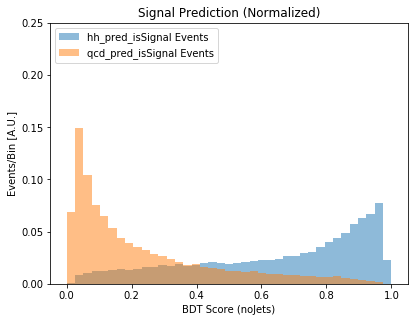

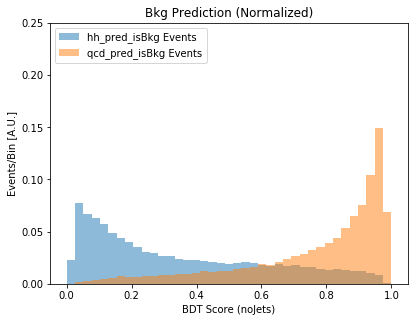

23724 34884
nSig = 1722.984 , nBkg = 1062687.73 with significance = 1.671392355292387 for BDT score > 0.8685213505770221


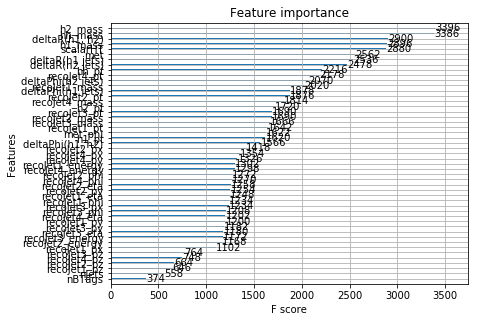

In [42]:
testingFraction = 0.3
model_noJets = makeDatasetsAndTrainModel( 'noJets', variables_noJets, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )


####### noJets #######
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
117214 rows of training data with  117214 labels [Train]
78143 rows of testing data with  78143 labels [Test]
[0]	logloss-merror:0.233698
Will train until logloss-merror hasn't improved in 3 rounds.
[1]	logloss-merror:0.227556
[2]	logloss-merror:0.222039
[3]	logloss-merror:0.218029
[4]	logloss-merror:0.215186
[5]	logloss-merror:0.215157
[6]	logloss-merror:0.213508
[7]	logloss-merror:0.211489
[8]	logloss-merror:0.211062
[9]	logloss-merror:0.211005
[10]	logloss-merror:0.210493
[11]	logloss-merror:0.209896
[12]	logloss-merror:0.21001
[13]	logloss-merror:0.209441
[14]	logloss-merror:0.208105
[15]	logloss-merror:0.207564
[16]	logloss-merror:0.20728
[17]	logloss-merror:0.20691
[18]	logloss-merror:0.206086
[19]	logloss-merror:0.206029
[20]	logloss-merror:0.205403
[21]	logloss-merror:0.205346
[22]	logloss-merror:0.205659
[23]	logloss-merror:0.204493
[24]	logloss-merror:0.204408
[25]

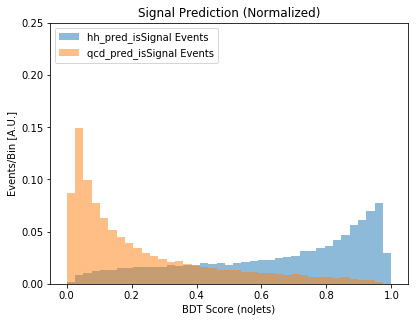

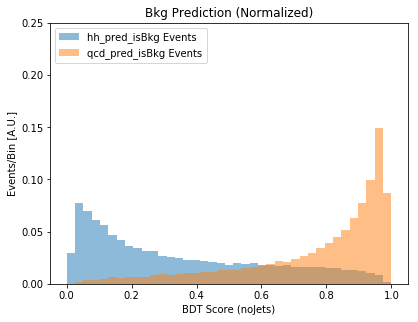

31578 46565
nSig = 1608.7157999999995 , nBkg = 886493.6625 with significance = 1.708604357657248 for BDT score > 0.880697574880388


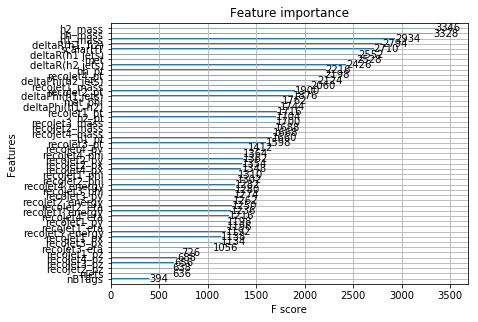

In [43]:
testingFraction = 0.4
model_noJets_frac40 = makeDatasetsAndTrainModel( 'noJets', variables_noJets, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )


####### noJets #######
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
97678 rows of training data with  97678 labels [Train]
97679 rows of testing data with  97679 labels [Test]
[0]	logloss-merror:0.234883
Will train until logloss-merror hasn't improved in 3 rounds.
[1]	logloss-merror:0.226829
[2]	logloss-merror:0.219697
[3]	logloss-merror:0.216899
[4]	logloss-merror:0.216353
[5]	logloss-merror:0.21294
[6]	logloss-merror:0.212258
[7]	logloss-merror:0.211473
[8]	logloss-merror:0.21079
[9]	logloss-merror:0.210278
[10]	logloss-merror:0.209255
[11]	logloss-merror:0.208982
[12]	logloss-merror:0.209391
[13]	logloss-merror:0.209186
[14]	logloss-merror:0.208811
[15]	logloss-merror:0.208265
[16]	logloss-merror:0.206661
[17]	logloss-merror:0.206149
[18]	logloss-merror:0.206047
[19]	logloss-merror:0.20574
[20]	logloss-merror:0.205842
[21]	logloss-merror:0.204955
[22]	logloss-merror:0.204477
[23]	logloss-merror:0.203897
[24]	logloss-merror:0.203863
[25]	l

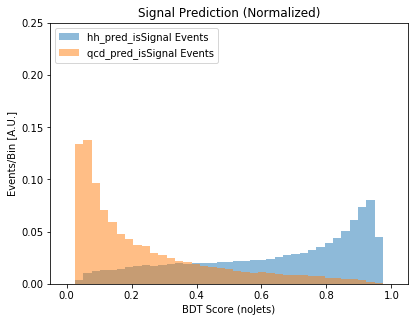

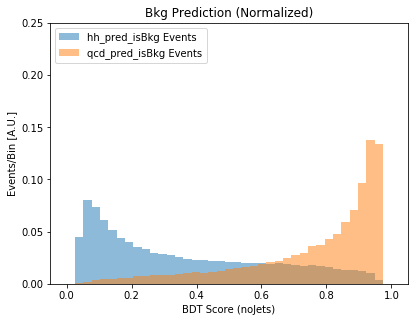

39448 58231
nSig = 1179.2923199999998 , nBkg = 493122.456 with significance = 1.6793610654982758 for BDT score > 0.896371495693621


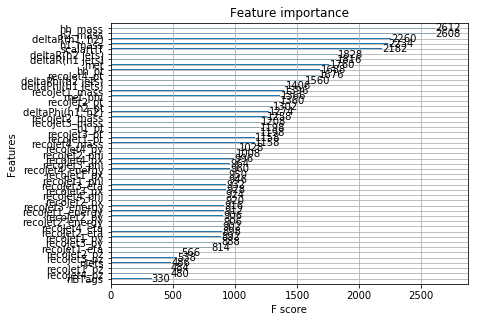

In [44]:
testingFraction = 0.5
model_noJets_frac50 = makeDatasetsAndTrainModel( 'noJets', variables_noJets, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )


####### noJets #######
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]
[0]	logloss-merror:0.232198
Will train until logloss-merror hasn't improved in 3 rounds.
[1]	logloss-merror:0.223752
[2]	logloss-merror:0.220908
[3]	logloss-merror:0.21886
[4]	logloss-merror:0.215135
[5]	logloss-merror:0.213599
[6]	logloss-merror:0.21286
[7]	logloss-merror:0.21195
[8]	logloss-merror:0.211381
[9]	logloss-merror:0.21067
[10]	logloss-merror:0.210898
[11]	logloss-merror:0.209333
[12]	logloss-merror:0.208935
[13]	logloss-merror:0.207684
[14]	logloss-merror:0.206518
[15]	logloss-merror:0.207001
[16]	logloss-merror:0.206774
[17]	logloss-merror:0.206347
[18]	logloss-merror:0.205978
[19]	logloss-merror:0.205238
[20]	logloss-merror:0.205523
[21]	logloss-merror:0.204442
[22]	logloss-merror:0.2043
[23]	logloss-merror:0.20467
[24]	logloss-merror:0.203674
[25]	log

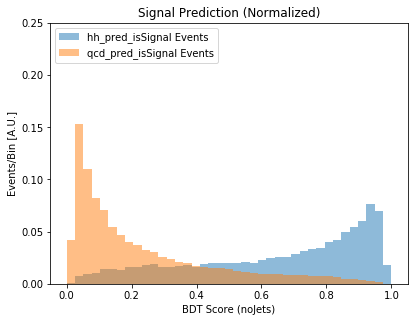

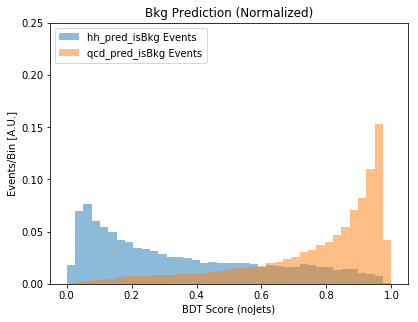

23724 34884
nSig = 1080.5112 , nBkg = 402098.06 with significance = 1.703975256320618 for BDT score > 0.9156631562350827


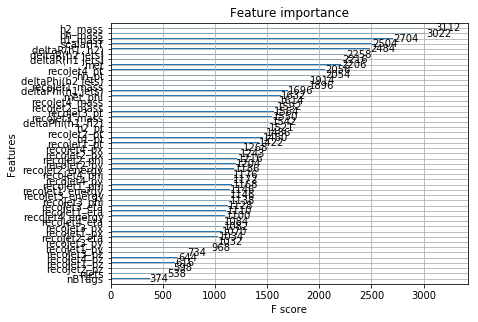

In [35]:
testingFraction = 0.3
model_noJets_trainFrac60 = makeDatasetsAndTrainModel( 'noJets', variables_noJets, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )


In [ ]:
pickle.dump(model_noJets, open('models/model.withRecoJetVars.pkl', 'wb'))

In [ ]:
model_noJets = makeDatasetsAndTrainModel( 'noJets', variables_noJets, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )
pickle.dump(model_noJets, open('models/model.noJetVars.pkl', 'wb'))

In [ ]:
# *** A. Make predictions 
sig_DMatrix = xgb.DMatrix(data_signal_test_bdt, label=labels_signal_test)
preds_sig   = loadedBDT.predict(sig_DMatrix)
bkg_DMatrix = xgb.DMatrix(data_bkg_test_bdt, label=labels_bkg_test)
preds_bkg   = loadedBDT.predict(bkg_DMatrix)

sig_pred_isSignal   = [x[1] for x in preds_sig]
bkg_pred_isSignal  = [x[1] for x in preds_bkg]

# *** F. Calculate significance 
returnBestCutValue('BDT', sig_pred_isSignal.copy(), bkg_pred_isSignal.copy(), _minBackground=4e5)


In [ ]:
model_noJets = makeDatasetsAndTrainModel( 'noJets', variables_noJets, testingFraction, hh_raw.copy(), qcd_raw.copy(), _makePlots=True )
